In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Data_Metal/train.csv')
df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [3]:
def load(image_id):
    
    path = '/content/drive/MyDrive/Data_Metal/train_images/'
    
    image = plt.imread(path + image_id)
    
    label = np.zeros(256 * 1600)
    
    where = df['ImageId'] == image_id

    for idx, (image_id, class_id, pixels) in df[where].iterrows():

        pixels = pixels.split()
        pixels = np.array(pixels, dtype=int)
        pixels = pixels.reshape(-1, 2)

        for start, length in pixels:
            label[start:start + length] = class_id

    label = label.reshape(256, 1600, order='F')
    
    return image, label

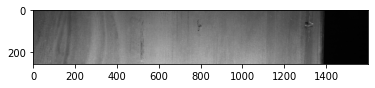

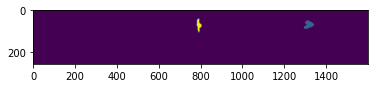

In [4]:
image_id = df.sample()['ImageId'].values[0]
image, label = load(image_id)
plt.imshow(image)
plt.show()
plt.imshow(label)
plt.show()

In [5]:
def f1_score(y_true, y_pred, c):
    
    y_pred = tf.argmax(y_pred, axis=-1)

    pred = tf.cast(y_pred == c, dtype=tf.float32)
    true = tf.cast(y_true == c, dtype=tf.float32)

    tp = tf.reduce_sum(pred * true)
    fp = tf.reduce_sum(pred * (1 - true))
    fn = tf.reduce_sum((1 - pred) * true)

    return tp / (tp + 0.5 * (fp + fn))


def f1_0(y_true, y_pred):
    return f1_score(y_true, y_pred, 0)

def f1_1(y_true, y_pred):
    return f1_score(y_true, y_pred, 1)

def f1_2(y_true, y_pred):
    return f1_score(y_true, y_pred, 2)

def f1_3(y_true, y_pred):
    return f1_score(y_true, y_pred, 3)

def f1_4(y_true, y_pred):
    return f1_score(y_true, y_pred, 4)

In [6]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Input((256, 1600, 3)),
    tf.keras.layers.Conv2D(16, (5, 5), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5, 5), strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.UpSampling2D(8),
    tf.keras.layers.Conv2D(5, (5, 5), padding='same', activation='softmax'),
])
metrics = [f1_0, f1_1, f1_2, f1_3, f1_4]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics, loss_weights=[0.001, 1, 1, 1, 1])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 800, 16)      1216      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 800, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 400, 32)       12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 400, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 200, 64)       51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 200, 64)       256       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 1600, 64)     0

In [7]:
class UNet(tf.keras.Model):
    
    def __init__(self):
        super(UNet, self).__init__()
        
        # Pooling Layers.
        self.maxpool = tf.keras.layers.MaxPool2D()
        
        # Convolution Layers.
        self.conv1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv9 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv10 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv11 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv12 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv13 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv14 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv15 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv16 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')
        self.conv17 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')
        self.conv18 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')

        # Transposed Convolution Layers.
        self.upconv1 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=2, padding='same', activation='relu')
        self.upconv2 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=2, padding='same', activation='relu')
        self.upconv3 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=2, padding='same', activation='relu')
        self.upconv4 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=2, padding='same', activation='relu')
        self.upconv5 = tf.keras.layers.Conv2DTranspose(5, (2, 2), strides=2, padding='same', activation='softmax')
        
        # Batch Normalization Layers.
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.bn4 = tf.keras.layers.BatchNormalization()
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.bn6 = tf.keras.layers.BatchNormalization()
        self.bn7 = tf.keras.layers.BatchNormalization()
        self.bn8 = tf.keras.layers.BatchNormalization()
        self.bn9 = tf.keras.layers.BatchNormalization()
        self.bn10 = tf.keras.layers.BatchNormalization()
        self.bn11 = tf.keras.layers.BatchNormalization()
        self.bn12 = tf.keras.layers.BatchNormalization()
        self.bn13 = tf.keras.layers.BatchNormalization()
        self.bn14 = tf.keras.layers.BatchNormalization()
        self.bn15 = tf.keras.layers.BatchNormalization()
        self.bn16 = tf.keras.layers.BatchNormalization()
        self.bn17 = tf.keras.layers.BatchNormalization()
        self.bn18 = tf.keras.layers.BatchNormalization()
        
    def call(self, x, training=False):
        
        x = x / 255
        
        x = self.bn1(self.conv1(x), training)
        x = self.bn2(self.conv2(x), training)
        x_2 = x
        
        x = self.maxpool(x)
        x = self.bn3(self.conv3(x), training)
        x = self.bn4(self.conv4(x), training)
        x_4 = x
        
        x = self.maxpool(x)
        x = self.bn5(self.conv5(x), training)
        x = self.bn6(self.conv6(x), training)
        x_6 = x
        
        x = self.maxpool(x)
        x = self.bn7(self.conv7(x), training)
        x = self.bn8(self.conv8(x), training)
        x_8 = x
        
        x = self.maxpool(x)
        x = self.bn9(self.conv9(x), training)
        x = self.bn10(self.conv10(x), training)
        
        x = self.upconv1(x)
        x = tf.concat([x, x_8], axis=-1)

        x = self.bn11(self.conv11(x), training)
        x = self.bn12(self.conv12(x), training)
        
        x = self.upconv2(x)
        x = tf.concat([x, x_6], axis=-1)
        
        x = self.bn13(self.conv13(x), training)
        x = self.bn14(self.conv14(x), training)
        
        x = self.upconv3(x)
        x = tf.concat([x, x_4], axis=-1)
        
        x = self.bn15(self.conv15(x), training)
        x = self.bn16(self.conv16(x), training)
        
        x = self.upconv4(x)
        x = tf.concat([x, x_2], axis=-1)
        
        x = self.bn17(self.conv17(x), training)
        x = self.bn18(self.conv18(x), training)
        
        x = self.upconv5(x)
        
        return x


tf.keras.backend.clear_session()
model = UNet()
metrics = [f1_0, f1_1, f1_2, f1_3, f1_4]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=metrics, loss_weights=[0.0001, 1, 1, 1, 1])
model.build(input_shape=(None, 128, 800, 3))
model.summary()
model(np.random.randn(10, 128, 800, 3)).shape

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2320      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  9248      
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  36928 

TensorShape([10, 256, 1600, 5])

In [8]:
ids = df['ImageId']
ids = ids.drop_duplicates()

ids_train = ids.sample(frac=0.8)
ids_valid = ids.drop(index=ids_train.index)

In [9]:
def gen(ids, batch_size):
    ids = ids.values

    while True:

        np.random.shuffle(ids)

        for i in range(0, ids.shape[0], batch_size):

            images = []
            labels = [] 

            for image_id in ids[i:i + batch_size]:
                image, label = load(image_id)
                image = cv2.resize(image, (800, 128))
                images.append(image)
                labels.append(label)

            images = np.array(images, copy=False)
            labels = np.array(labels, copy=False)

            yield images, labels

In [ ]:
hist = model.fit(
    # train dataset generator.
    gen(ids_train, 64),
    # valid dataset generator.
    validation_data = gen(ids_valid, 128),
    # number of steps for train set.
    steps_per_epoch = np.ceil(ids_train.shape[0] / 64).astype('int'),
    # number of steps for valid set.
    validation_steps = np.ceil(ids_valid.shape[0] / 128).astype('int'),
    # number of epochs.
    epochs = 10
)

Epoch 1/10


Написать в презентацию сколько на валидацию и тренировку

In [ ]:
plt.title('F1 Score for each classes in validation set')
plt.plot(hist.history['val_f1_0'], label='val_f1_0')
plt.plot(hist.history['val_f1_1'], label='val_f1_1')
plt.plot(hist.history['val_f1_2'], label='val_f1_2')
plt.plot(hist.history['val_f1_3'], label='val_f1_3')
plt.plot(hist.history['val_f1_4'], label='val_f1_4')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

weights_file = 'weights.h5'
callback = ModelCheckpoint(weights_file,
              monitor='acc',
              mode='max',
              save_best_only=True)

Пример работы неронной сети на основе первой картинки из train выборки


In [ ]:
image_id = df.sample()['ImageId'].values[0]
image, label = load(image_id)
plt.imshow(image)
plt.show()
plt.imshow(label)
plt.show()

In [ ]:
print(image.shape)

In [ ]:
def load_new_img(path):
    
    image = plt.imread(path)
    size_img = image.shape[:2]
    print(size_img)
    image = cv2.resize(image, (800, 128))

    pred = model(image[np.newaxis, ...])
    #print(pred)
    pred = np.argmax(pred, axis=-1)
    print('+', image.shape, pred[0].shape)
    #image = cv2.resize(image, size_img)
    #pred_img = cv2.resize(pred[0], size_img)
    print(image.shape, pred[0].shape)
    fig, axs = plt.subplots(2, 1, figsize=[20, 10])
    
    axs[0].imshow(image)
    #axs[1].imshow(label)
    axs[1].imshow(pred[0])
    fig.show()

In [ ]:
image = load_new_img('/content/post-28616-087717300 1368026780.jpg')